<div style="background-color: #22014d; padding: 20px; border-radius: 10px;">
    <h1 style="color: white;">Improve a Fixed Model the Data-Centric Way!</h1>
    <p style="color: white; font-size: 18px;">Playground Series - Season 3, Episode 21</p>
    <p><b style="color: white;">Author: Tony Hollaar</b></p>
    <p><b style="color: white;">Date: 08/22/2023</b></p>
    <p><b style="color: white;"> Goal: Obtain a lower <i><b style="color: yellow;">`Mean Absolute Error`</b></i>
        than provided <b style="color: yellow;">sample_submission.csv</b> which has MAE score of <b style="color: yellow;">0.79226</b>.
        <br>
        Improve the train dataset for a provided Random Forest Model with a hidden test-dataset
        which is scored by evaluation metric: <b style="color: white;"> Mean Absolute Error </b>.
    </p>
</div>


<div class="header">
    <h1>📜 Table of Contents</h1>
</div>

1. [Dataset Description](#Description)
2. [Import Libraries](#import)
3. [Load Datasets](#Load_Data)
4. [Exploratory Data Analysis](#EDA)
    * [Domain Knowledge](#EDA_Domain_Knowledge)
    * [Plots](#EDA_Plots)
        * [Missing Values Plots](#EDA_Missing)
        * [Histogram Plots](#EDA_Histogram)
        * [Violin Plots](#EDA_Violin_Plots)
        * [Box Plots](#EDA_Box_Plots)
5. [Random Forest Model](#Model)
    * [Baseline](#Baseline)

<a class="anchor"  id="configuration"></a>
<div class="header">
    <h1>⚙️ Setting Configuration</h1>
</div>

Link Emoji finder: https://emojifinder.com/text

In [148]:
# Define your custom CSS styling
custom_css = """
:root{
    --box_color: #e6f7ff;
}

/* Your custom CSS rules go here */
body[data-jp-theme-light="true"] .jp-Notebook .CodeMirror.cm-s-jupyter {
    background-color: var(--box_color) !important;
}


body {
    background-color: #f5f5f5;
    font-family: Arial, sans-serif;
    font-size: 14px;
    color: #333;
}

h1 {
    color: #007bff;
    font-size: 24px;
}

/* Add styling for your header */
.header {
    background-color: #22014d;
    border-radius: 10px;
    border: 2px solid #f2c221; /* Border color that works well */
    padding: 5px;
    margin-bottom: 5px; /* Optional margin for spacing */
    overflow: hidden; /* Ensure child elements don't overflow */
}

.header h1 {
    color: white;
    margin: 0;
    padding: 5px;
}

/* Change code cell background color */
div.input,
div.code_cell {
    background-color: #ffd700; /* Change this color as desired */
}

/* Add more custom styling rules as needed */
"""

# Apply the custom CSS using the HTML class
from IPython.core.display import HTML
HTML("<style>" + custom_css + "</style>")

# FUNCTIONS

In [146]:
# Define a decorator to measure the time it takes to run a function
def timer_decorator(func):
    # The wrapper function that calculates and displays the execution time.
    def wrapper(*args, **kwargs):
        start_time = datetime.now()
        result = func(*args, **kwargs)
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        hours, remainder = divmod(elapsed_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Time taken: {hours} hours, {minutes} minutes, {seconds} seconds")
        return result
    return wrapper

<a class="anchor"  id="Description"></a>

<div class="header">
    <h1>📝 Dataset Description</h1>
</div>

This is a very different type of challenge! For this challenge, your task is to improve a dataset that is being used to train a random forest model; in other words, your submission will be training data, not predictions. A random forest model will be trained on your submission, used to make predictions, and then those predictions will be used to generate your score.

The dataset for this competition is a synthetic dataset based off of the Dissolved oxygen prediction in river water dataset. You are free to use the original in any way that you find useful.

Please see important information on the Evaluation tab about the model that will be trained on your submitted data.

<b> source: </b> https://www.kaggle.com/competitions/playground-series-s3e21/data

## Helpful Links:
- Domain Knowledge Links: https://www.kaggle.com/competitions/playground-series-s3e21/discussion/433479l


### Data Details
- <b> target </b>: Dissolved Oxygen (DO) in river water
- <b> O2 </b> Features: <i style="color: #999;"> 1 through 7 labelled O2_1, ..., O2_7 </i>
- <b> NH4 </b> Features: <i style="color: #999;"> 1 through 7 labelled NH4_1, ..., NH4_7 </i>
    - <i> Ammonium </i> can have a <i style="color:red;"> negative </i> impact on <b> Dissolved Oxygen </b> levels by promoting processes that consume oxygen, such as nitrification and organic matter decomposition
- <b> NO2 </b> Features: <i style="color: #999;"> 1 through 7 labelled NO2_1, ..., NO2_7 </i>
- <b> NO3 </b> Features: <i style="color: #999;"> 1 through 7 labelled NO3_1, ..., NO3_7 </i>
- <b> BOD5 </b> Features: <i style="color: #999;"> 1 through 7 labelled BOD5_1, ..., BOD5_7 </i>


<a class="anchor"  id="import"></a>
<div class="header">
    <h1>📚 Import Libraries</h1>
</div>

In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import missingno as msno # missing values plots
import plotly.express as px # plotting package
import plotly.io as pio
pio.renderers.default = 'notebook'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e21/sample_submission.csv
/kaggle/input/oxygen-img/dissolved_oxygen.png


<a class="anchor"  id="Load_Data"></a>
<div class="header">
    <h1>💾 Load Data</h1>
</div>

In [142]:
# read sample submission file
df = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

# download sample submission file. Note: exclude index column
#df.to_csv('sample_submission.csv', index=False)

In [143]:
df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


<a class="anchor"  id="EDA"></a>
<div class="header">
    <h1>🔍 Exploratory Data Analysis</h1>
</div>

<a class="anchor"  id="EDA_Domain_Knowledge"></a>
# Domain Knowledge
---

### Dissolved Oxygen in Water
- Link Article: https://www.knowyourh2o.com/outdoor-4/dissolved-oxygen-in-water
    - <b> Range DO </b>: Dissolved Oxygen (DO) in a stream may vary from <b> 0 mg/l to 18 mg/l </b>. Readings above 18 mg/l are physically impossible at Earth’s surface.
        - <i> Assumption: </i> values in target column below 0 or above 18mg/l can be considered an outlier 

In [99]:
print('The number of rows in the dataframe:', df.shape[0])
print('The number of columns in the dataframe:', df.shape[1])

The number of rows in the dataframe: 3500
The number of columns in the dataframe: 37


In [101]:
df.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [49]:
df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,1749.500000,8.473834,8.216993,9.291581,9.633064,8.065733,5.671581,9.461363,6.547433,0.340525,...,8.710466,3.002243,3.242654,4.816718,4.754389,4.285660,5.968980,7.837995,3.750349,4.068639
std,1010.507298,1.885712,3.040743,6.817822,1.439039,1.463881,2.721399,1.140365,1.663266,0.284751,...,6.438648,2.918355,2.713923,2.009161,1.547491,2.093388,2.576146,3.724861,1.682421,1.894632
min,0.000000,1.300000,0.000000,0.000000,4.900000,2.300000,0.200000,0.000000,0.000000,0.020000,...,0.044000,0.011000,0.000000,0.570000,0.089000,0.850000,2.025000,2.020000,0.364000,1.600000
25%,874.750000,7.470000,7.100000,7.300000,8.770000,6.830000,4.550000,8.980000,5.877500,0.214500,...,4.450000,1.140000,1.780000,3.520000,3.950000,2.290000,4.950000,5.725000,2.684000,2.900000
50%,1749.500000,8.280000,7.890000,8.300000,9.500000,7.980000,5.800000,9.430000,6.430000,0.247000,...,6.054000,1.730000,1.800000,4.600000,4.800000,3.950000,5.725000,7.500000,3.500000,3.700000
75%,2624.250000,9.110000,9.100000,8.700000,9.545000,9.265000,7.015000,10.070000,7.150000,0.370000,...,14.515000,3.025000,4.237500,5.000000,5.400000,4.725000,6.250000,8.400000,4.150000,4.450000
max,3499.000000,65.930000,46.950000,65.950000,16.900000,21.800000,59.400000,40.190000,15.900000,4.200000,...,35.000000,19.355000,27.025000,11.650000,10.700000,19.800000,55.400000,82.450000,19.375000,10.370000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3500 non-null   int64  
 1   target  3500 non-null   float64
 2   O2_1    3500 non-null   float64
 3   O2_2    3500 non-null   float64
 4   O2_3    3500 non-null   float64
 5   O2_4    3500 non-null   float64
 6   O2_5    3500 non-null   float64
 7   O2_6    3500 non-null   float64
 8   O2_7    3500 non-null   float64
 9   NH4_1   3500 non-null   float64
 10  NH4_2   3500 non-null   float64
 11  NH4_3   3500 non-null   float64
 12  NH4_4   3500 non-null   float64
 13  NH4_5   3500 non-null   float64
 14  NH4_6   3500 non-null   float64
 15  NH4_7   3500 non-null   float64
 16  NO2_1   3500 non-null   float64
 17  NO2_2   3500 non-null   float64
 18  NO2_3   3500 non-null   float64
 19  NO2_4   3500 non-null   float64
 20  NO2_5   3500 non-null   float64
 21  NO2_6   3500 non-null   float64
 22  

<a class="anchor"  id="EDA_Plots"></a>
# EDA - Plots
---

<a class="anchor"  id="EDA_Missing"></a>
#### Check Missing Values

<Axes: >

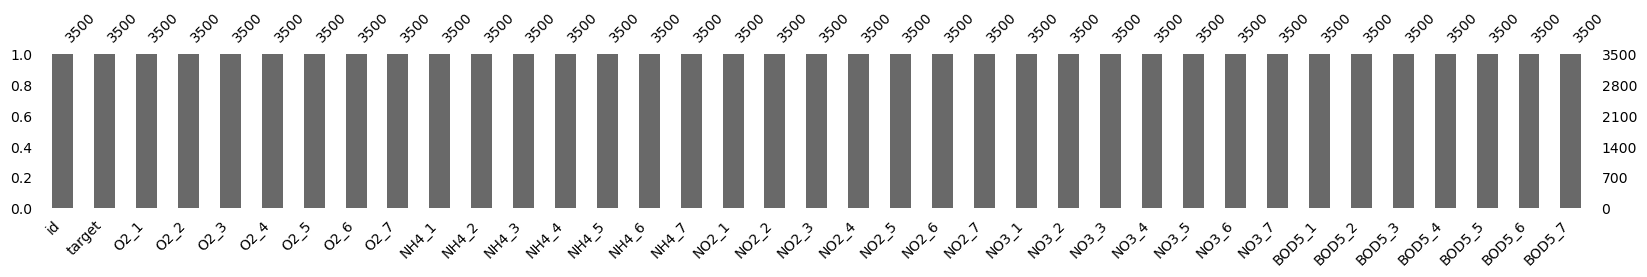

In [82]:
msno.bar(df, figsize=(20, 2), fontsize=10)

<a class="anchor"  id="EDA_Histogram"></a>
# Histogram Plots
---

In [83]:
# Create a histogram using Plotly Express
fig = px.histogram(df, x='target', nbins=10000, title='Histogram of Target Values')
# Show the plot
fig.show()

<a class="anchor"  id="EDA_Violin_Plots"></a>
# Violin Plots
---

In [54]:
# Create a violin plot using Plotly Express
fig = px.violin(df, y='target', title='Violin Plot of Target Values')

# Show the plot
fig.show()

<a class="anchor"  id="EDA_Box_Plots"></a>
# Box Plots
---

In [55]:
# Create a box plot using Plotly Express
fig = px.box(df, y='target', title='Box Plot of Target Values')

# Show the plot
fig.show()

<a class="anchor"  id="configuration"></a>
<div class="header">
    <h1>⚒️ Pre-processing</h1>
</div>

<a class="anchor"  id="Model"></a>
<div class="header">
    <h1>🚂 Model Training</h1>
</div>

<a class="anchor"  id="Baseline"></a>
# BASELINE

In [144]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

# Define the RandomForestRegressor model
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

# Split the DataFrame into features (X) and target (y)
X = df.drop(columns=['target'])
y = df['target']

# Define a function to perform cross-validation and calculate average MAE
@timer_decorator
def calculate_average_mae(model, X, y, cv_folds):
    # Perform cross-validation and calculate MAE for each fold
    cv_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_absolute_error')
    mae_scores = -cv_scores  # Convert negative scores to positive MAE
    
    # Calculate the average MAE across all cross-validation folds
    average_mae = np.mean(mae_scores)
    return average_mae

# Call the function with the defined model and data
cv_folds = 5  # Number of cross-validation folds
average_mae = calculate_average_mae(rf, X, y, cv_folds)
print(f"Average MAE from cross-validation: {average_mae:.6f}")

Time taken: 0 hours, 0 minutes, 44 seconds
Average MAE from cross-validation: 0.771904


<div style="border-radius: 10px; border: #f2c221 solid; padding: 15px; background-color: #e6f7ff; font-size: 100%; text-align: left;">
    <h3 align="left"><font color="black">💡 Baseline Scores </font></h3>
    <p style="color: black;">
        - LB score of submission of original <code>sample_submission.csv</code> used as train-set and trained model run on hidden test-set is 0.79226 <br>
        - Cross-validation of <code>sample_submission.csv</code> in-sample against provided Random Forest Model is relatively close with e.g. 0.771904
    </p>
</div>
